# Avito Demand Prediction

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

color = sns.color_palette()
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import warnings
warnings.filterwarnings("ignore")

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999

In [2]:
train = pd.read_csv('train.csv', parse_dates=['activation_date'])
test = pd.read_csv('test.csv', parse_dates=['activation_date'])
ntrain = train.shape[0]
ntest = test.shape[0]
train_index = train.index
test_index = test.index
test_id = test['item_id']
print('%d train samples' % ntrain)
print('%d test samples' % ntest)

1503424 train samples
508438 test samples


In [4]:
train.head()

,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,description,price,item_seq_number,activation_date,user_type,image,image_top_1,deal_probability
0,b912c3c6a6ad,e00f8ff2eaf9,Свердловская область,Екатеринбург,Личные вещи,Товары для детей и игрушки,Постельные принадлежности,NaN,NaN,Кокоби(кокон для сна),"Кокон для сна малыша,пользовались меньше месяц...",400.0,2,2017-03-28,Private,d10c7e016e03247a3bf2d13348fe959fe6f436c1caf64c...,1008.0,0.12789
1,2dac0150717d,39aeb48f0017,Самарская область,Самара,Для дома и дачи,Мебель и интерьер,Другое,NaN,NaN,Стойка для Одежды,"Стойка для одежды, под вешалки. С бутика.",3000.0,19,2017-03-26,Private,79c9392cc51a9c81c6eb91eceb8e552171db39d7142700...,692.0,0.00000
2,ba83aefab5dc,91e2f88dd6e3,Ростовская область,Ростов-на-Дону,Бытовая электроника,Аудио и видео,"Видео, DVD и Blu-ray плееры",NaN,NaN,Philips bluray,"В хорошем состоянии, домашний кинотеатр с blu ...",4000.0,9,2017-03-20,Private,b7f250ee3f39e1fedd77c141f273703f4a9be59db4b48a...,3032.0,0.43177
3,02996f1dd2ea,bf5cccea572d,Татарстан,Набережные Челны,Личные вещи,Товары для детей и игрушки,Автомобильные кресла,NaN,NaN,Автокресло,Продам кресло от0-25кг,2200.0,286,2017-03-25,Company,e6ef97e0725637ea84e3d203e82dadb43ed3cc0a1c8413...,796.0,0.80323
4,7c90be56d2ab,ef50846afc0b,Волгоградская область,Волгоград,Транспорт,Автомобили,С пробегом,ВАЗ (LADA),2110,"ВАЗ 2110, 2003",Все вопросы по телефону.,40000.0,3,2017-03-16,Private,54a687a3a0fc1d68aed99bdaaf551c5c70b761b16fd0a2...,2264.0,0.20797


Dataset description:  
- item_id - Ad id.  
- user_id - User id.  
- region - Ad region.  
- city - Ad city.  
- parent_category_name - Top level ad category as classified by Avito's ad model.  
- category_name - Fine grain ad category as classified by Avito's ad model.  
- param_1 - Optional parameter from Avito's ad model.  
- param_2 - Optional parameter from Avito's ad model.  
- param_3 - Optional parameter from Avito's ad model.  
- title - Ad title.  
- description - Ad description.  
- price - Ad price.  
- item_seq_number - Ad sequential number for user.  
- activation_date- Date ad was placed.  
- user_type - User type.  
- image - Id code of image. Ties to a jpg file in train_jpg. Not every ad has an image.  
- image_top_1 - Avito's classification code for the image.  
- deal_probability - The target variable. This is the likelihood that an ad actually sold something. It's not possible to verify every transaction with certainty, so this column's value can be any float from zero to one.

## EDA & Feature Engineering  

## Numerical & Categorical Features

### Deal Probability

- 65% (974K) ads have 0 deal probability.  
- 23% ads have a deal probability lower than 0.5.  
- 11% ads have a deal probability higher than 0.7. They are likely to lead to sales.

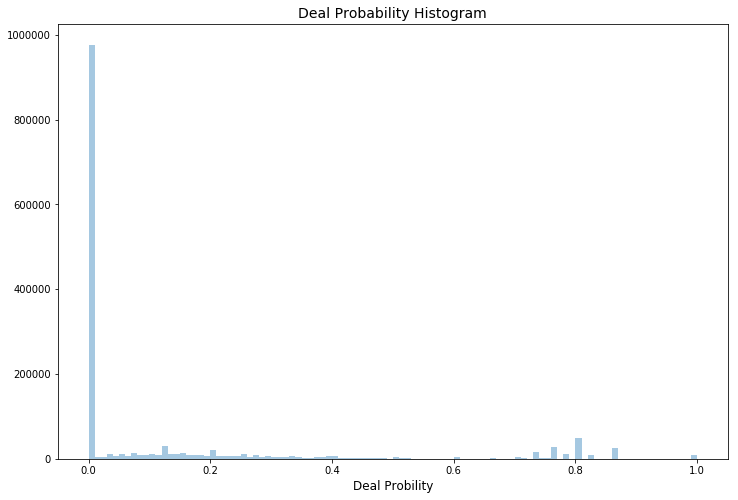

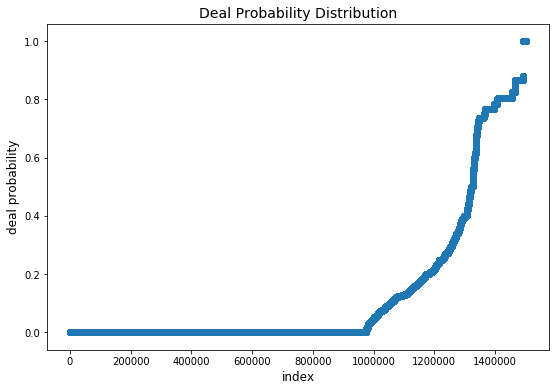

In [5]:
plt.figure(figsize=(12,8))
sns.distplot(train['deal_probability'].values, bins=100, kde=False)
plt.xlabel('Deal Probility', fontsize=12)
plt.title("Deal Probability Histogram", fontsize=14)
plt.show()

plt.figure(figsize=(9,6))
plt.scatter(range(train.shape[0]), np.sort(train['deal_probability'].values))
plt.xlabel('index', fontsize=12)
plt.ylabel('deal probability', fontsize=12)
plt.title("Deal Probability Distribution", fontsize=14)
plt.show()

In [6]:
print('Deal probability is 0: ', 1-len(train[train['deal_probability']>0])/ntrain)
print('Deal probability is 0-0.5: ', len(train[(train['deal_probability']>0) & (train['deal_probability']<0.5)])/ntrain)
print('Deal probability is 0.5-0.7: ', len(train[(train['deal_probability']>=0.5) & (train['deal_probability']<0.7)])/ntrain)
print('Deal probability is 0.7-0.8: ', len(train[(train['deal_probability']>=0.7) & (train['deal_probability']<0.8)])/ntrain)
print('Deal probability is 0.8-0.9: ', len(train[(train['deal_probability']>=0.8) & (train['deal_probability']<0.9)])/ntrain)
print('Deal probability higher than 0.9: ', len(train[train['deal_probability']>=0.9])/ntrain)

Deal probability is 0:  0.6482655591503128
Deal probability is 0-0.5:  0.23066879336767274
Deal probability is 0.5-0.7:  0.012616533991741518
Deal probability is 0.7-0.8:  0.04409467987739985
Deal probability is 0.8-0.9:  0.05765239879102635
Deal probability higher than 0.9:  0.0067020348218466645


#### Deal Probability by Region

In [7]:
from io import StringIO

translation = StringIO("""
region,region_en
Свердловская область, Sverdlovsk oblast
Самарская область, Samara oblast
Ростовская область, Rostov oblast
Татарстан, Tatarstan
Волгоградская область, Volgograd oblast
Нижегородская область, Nizhny Novgorod oblast
Пермский край, Perm Krai
Оренбургская область, Orenburg oblast
Ханты-Мансийский АО, Khanty-Mansi Autonomous Okrug
Тюменская область, Tyumen oblast
Башкортостан, Bashkortostan
Краснодарский край, Krasnodar Krai
Новосибирская область, Novosibirsk oblast
Омская область, Omsk oblast
Белгородская область, Belgorod oblast
Челябинская область, Chelyabinsk oblast
Воронежская область, Voronezh oblast
Кемеровская область, Kemerovo oblast
Саратовская область, Saratov oblast
Владимирская область, Vladimir oblast
Калининградская область, Kaliningrad oblast
Красноярский край, Krasnoyarsk Krai
Ярославская область, Yaroslavl oblast
Удмуртия, Udmurtia
Алтайский край, Altai Krai
Иркутская область, Irkutsk oblast
Ставропольский край, Stavropol Krai
Тульская область, Tula oblast
""")

region_df = pd.read_csv(translation)
train = pd.merge(train, region_df, how="left", on="region")

region_counts = train['region_en'].value_counts().sort_values(ascending=False)
region_distribution = (region_counts/region_counts.sum())*100

print('Region Distribution')
print(region_distribution.iloc[:])

Region Distribution
 Krasnodar Krai                   9.406262
 Sverdlovsk oblast                6.283989
 Rostov oblast                    5.986003
 Tatarstan                        5.406592
 Chelyabinsk oblast               5.210706
 Nizhny Novgorod oblast           4.898352
 Samara oblast                    4.882655
 Bashkortostan                    4.542365
 Perm Krai                        4.170746
 Novosibirsk oblast               4.156246
 Krasnoyarsk Krai                 3.554686
 Saratov oblast                   3.302129
 Volgograd oblast                 3.259094
 Kemerovo oblast                  2.968890
 Voronezh oblast                  2.934368
 Irkutsk oblast                   2.928648
 Omsk oblast                      2.856081
 Altai Krai                       2.761696
 Stavropol Krai                   2.606517
 Tyumen oblast                    2.355357
 Yaroslavl oblast                 2.182618
 Kaliningrad oblast               2.178760
 Orenburg oblast                  

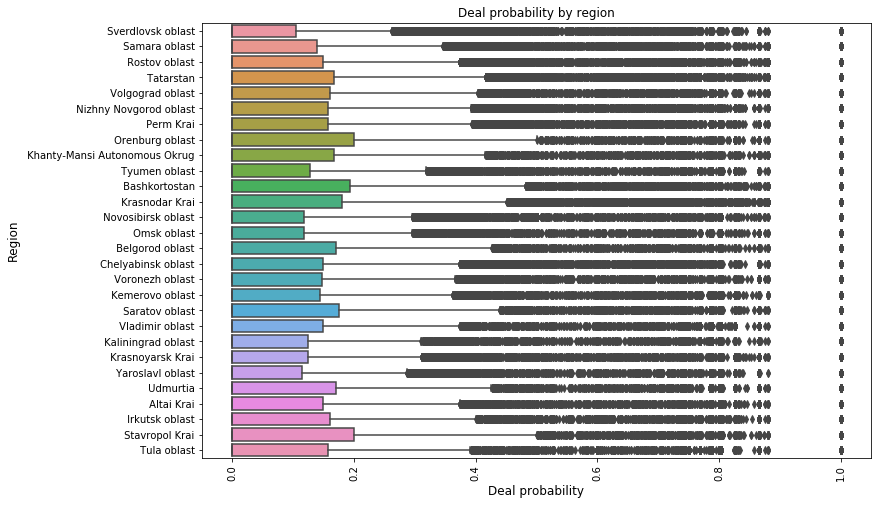

In [8]:
plt.figure(figsize=(12,8))
sns.boxplot(y="region_en", x="deal_probability", data=train)
plt.xlabel('Deal probability', fontsize=12)
plt.ylabel('Region', fontsize=12)
plt.title("Deal probability by region")
plt.xticks(rotation='vertical')
plt.show()

#### Deal Probability by Parent Category

Top 3 :
- Services
- Transportation
- Animals

In [9]:
translation = StringIO("""
parent_category_name,parent_category_name_en
Личные вещи,Personal belongings
Для дома и дачи,For the home and garden
Бытовая электроника,Consumer electronics
Недвижимость,Real estate
Хобби и отдых,Hobbies & leisure
Транспорт,Transport
Услуги,Services
Животные,Animals
Для бизнеса,For business
""")

parent_cat_df = pd.read_csv(translation)
train = pd.merge(train, parent_cat_df, on="parent_category_name", how="left")

parent_cat_counts = train['parent_category_name_en'].value_counts().sort_values(ascending=False)
parent_cat_distribution = (parent_cat_counts/parent_cat_counts.sum())*100

print('Parent Category Distribution')
print(parent_cat_distribution.iloc[:])

Parent Category Distribution
Personal belongings        46.402279
For the home and garden    11.894382
Consumer electronics       11.507599
Real estate                10.189408
Hobbies & leisure           5.721008
Transport                   5.310478
Services                    4.282558
Animals                     3.490033
For business                1.202256
Name: parent_category_name_en, dtype: float64


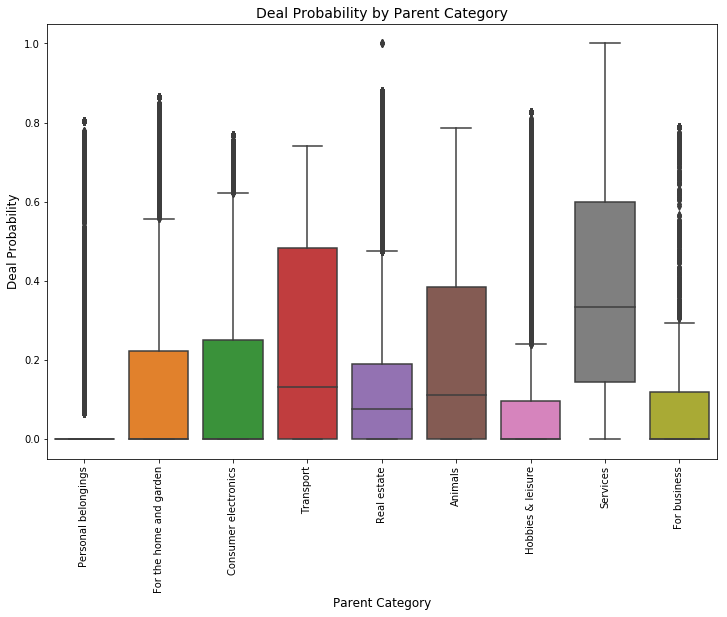

In [10]:
plt.figure(figsize=(12,8))
sns.boxplot(x="parent_category_name_en", y="deal_probability", data=train)
plt.ylabel('Deal Probability', fontsize=12)
plt.xlabel('Parent Category', fontsize=12)
plt.title("Deal Probability by Parent Category", fontsize=14)
plt.xticks(rotation='vertical')
plt.show()

#### Deal Probability by User Type

Deal probability: private > company > shop. 
User distribution is unbalance.

In [12]:
user_type_counts = train['user_type'].value_counts().sort_values(ascending=False)
user_type_distribution = (user_type_counts/user_type_counts.sum())*100
print('User Type Distribution')
print(user_type_distribution)

User Type Distribution
Private    71.550408
Company    23.097210
Shop        5.352382
Name: user_type, dtype: float64


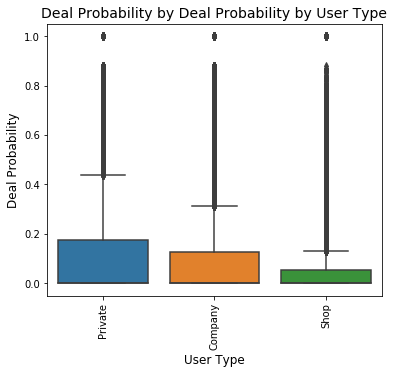

In [13]:
plt.figure(figsize=(6,5))
sns.boxplot(x="user_type", y="deal_probability", data=train)
plt.ylabel('Deal Probability', fontsize=12)
plt.xlabel('User Type', fontsize=12)
plt.title("Deal Probability by Deal Probability by User Type", fontsize=14)
plt.xticks(rotation='vertical')
plt.show()

### Price

- Most (75%) ads sell products under 7000 (approx. 100 USD). While the maximum price is 79.5M.
- Price distribution is skewed.

In [14]:
print(train['price'].describe())
price_df = pd.concat([train['price'], test['price']],axis=0)
price_df.isnull().sum()

count    1.418062e+06
mean     3.167081e+05
std      6.689154e+07
min      0.000000e+00
25%      5.000000e+02
50%      1.300000e+03
75%      7.000000e+03
max      7.950101e+10
Name: price, dtype: float64


115947

In [15]:
# convert price to log form
price_df.fillna(price_df.mean(), inplace=True)
price_df = np.log(price_df+1)

In [16]:
train['price'] = price_df[:ntrain]
test['price'] = price_df[ntrain:]

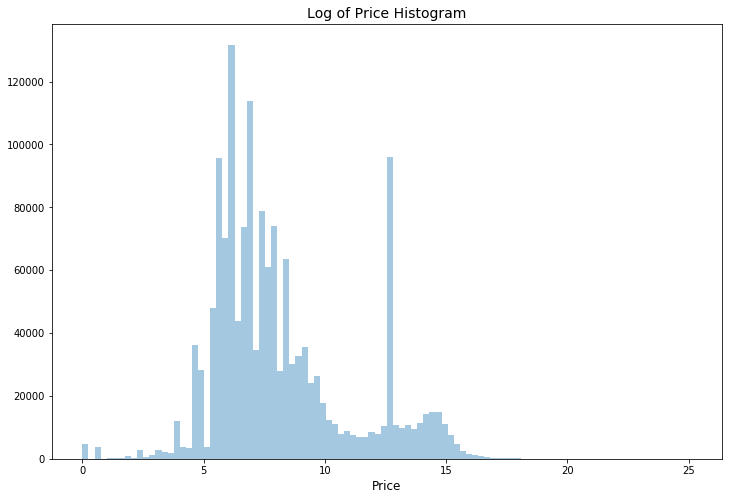

In [17]:
plt.figure(figsize=(12,8))
sns.distplot(train['price'].values, bins=100, kde=False)
plt.xlabel('Price', fontsize=12)
plt.title("Log of Price Histogram", fontsize=14)
plt.show()

#### Price by Parent Category

Top 3: 
- Real estate
- Transportation
- For business

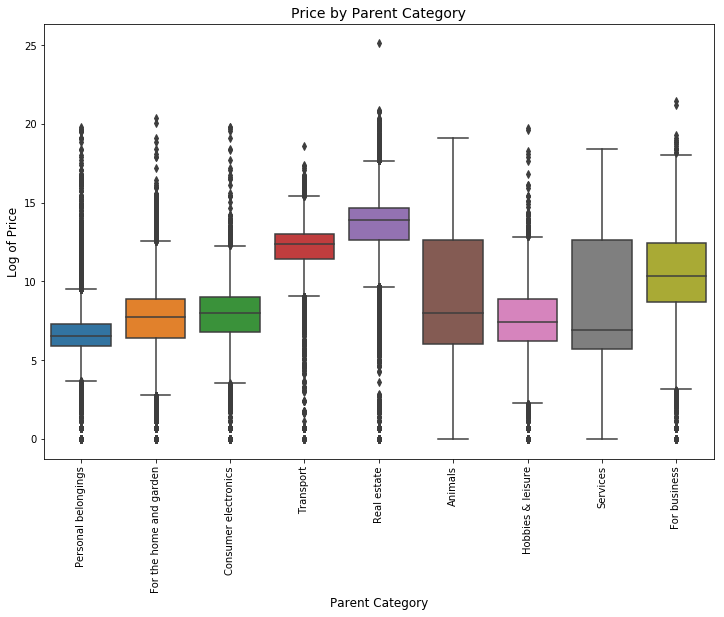

In [18]:
plt.figure(figsize=(12,8))
sns.boxplot(x="parent_category_name_en", y="price", data=train)
plt.ylim
plt.ylabel('Log of Price', fontsize=12)
plt.xlabel('Parent Category', fontsize=12)
plt.title("Price by Parent Category", fontsize=14)
plt.xticks(rotation='vertical')
plt.show()

In [19]:
del price_df

### Length of Title

- Many of the titles are around 1-4 words

![titile](2_title_len.png)

In [ ]:
train['title'] = train['title'].fillna(' ')
train['title_len'] = train['title'].apply(lambda x : len(x.split()))
test['title'] = test['title'].fillna(' ')
test['title_len'] = test['title'].apply(lambda x : len(x.split()))

cnt = train['title_len'].value_counts()

trace = go.Bar(
    x=cnt.index,
    y=cnt.values,
    marker=dict(
        color="blue",
        reversescale = True
    ),
)

layout = go.Layout(
    title='Length of Title'
)

data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="title_len")

### Length of Description

- Generally short, around 3-10 words, less than 20 words.
- Around 115K have no descriptions.

![titile](3_desc_len.png)

In [ ]:
train['description'] = train['description'].fillna(' ')
train['description_len'] = train['description'].apply(lambda x : len(x.split()))
test['description'] = test['description'].fillna(' ')
test['description_len'] = test['description'].apply(lambda x : len(x.split()))

cnt = train['description_len'].value_counts().head(100)

trace = go.Bar(
    x=cnt.index,
    y=cnt.values,
    marker=dict(
        color="blue",
        reversescale = True
    ),
)

layout = go.Layout(
    title='Length of Description'
)

data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="description_len")

### Activation Date

- Train set: Mar 15-28, 2017
- Test set: Apr 12-18, 2017

![title](4_activation_train.png)

![title](5_activation_test.png)

In [ ]:
# activation dates in train data
cnt = train['activation_date'].value_counts()
trace = go.Bar(
    x=cnt.index,
    y=cnt.values,
    marker=dict(
        color="blue",
        reversescale = True
    ),
)

layout = go.Layout(
    title='Activation dates in train data'
)

data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="activation_date_train")

# activation dates in test data
cnt = test['activation_date'].value_counts()
trace = go.Bar(
    x=cnt.index,
    y=cnt.values,
    marker=dict(
        color="blue",
        reversescale = True
    ),
)

layout = go.Layout(
    title='Activation dates in test data'
)

data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="activation_date_test")

#### Weekday on which the ads were activated

![title](6_weekday_train.png)

![title](7_weekday_test.png)

In [ ]:
# activation by weekday in train data
train['weekday'] = train.activation_date.dt.weekday
cnt = train['weekday'].value_counts()

trace = go.Bar(
    x=cnt.index,
    y=cnt.values,
    marker=dict(
        color="blue",
        reversescale = True
    ),
)

layout = go.Layout(
    title='Activation by weekday in train data'
)

data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="activation_weekday_train")

# activation by weekday in test data
test['weekday'] = test.activation_date.dt.weekday
cnt = test['weekday'].value_counts()
trace = go.Bar(
    x=cnt.index,
    y=cnt.values,
    marker=dict(
        color="blue",
        reversescale = True
    ),
)

layout = go.Layout(
    title='Activation by weekday in test data'
)

data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="activation_weekday_test")

#### Total number of days the ads were run

Mode of period:
- 13 days in train set
- 6 days in test set

![title](8_periods_train.png)

![title](9_periods_test.png)

In [24]:
periods_train = pd.read_csv("periods_train.csv", parse_dates=["activation_date", "date_from", "date_to"])
train['period'] = periods_train['date_to'] - periods_train['date_from']
periods_test = pd.read_csv("periods_test.csv", parse_dates=["activation_date", "date_from", "date_to"])
test['period'] = periods_test['date_to'] - periods_test['date_from']

del periods_train, periods_test

In [ ]:
# period in train data
train['period'] = train['period'].dt.days
cnt = train['period'].value_counts()
trace = go.Bar(
    x=cnt.index,
    y=cnt.values,
    marker=dict(
        color="blue",
        reversescale = True
    ),
)

layout = go.Layout(
    title='Periods in train data'
)

data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="periods_train")

# period in test data
test['period'] = test['period'].dt.days
cnt = test['period'].value_counts()
trace = go.Bar(
    x=cnt.index,
    y=cnt.values,
    marker=dict(
        color="blue",
        reversescale = True
    ),
)

layout = go.Layout(
    title='Periods in test data'
)
data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="periods_test")

### Correaltions between deal probability and numeric features

price               0.068444
title_len           0.016143
description_len    -0.000968
period             -0.000638
item_seq_number    -0.035744
deal_probability    1.000000
Name: deal_probability, dtype: float64


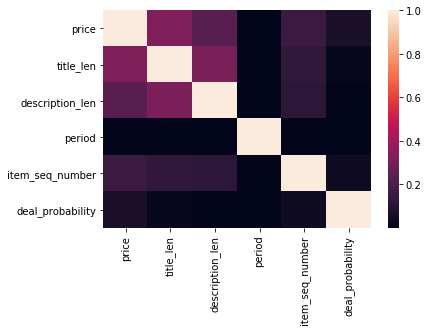

In [26]:
numeric_cols = ['price', 'title_len', 'description_len', 'period', 'item_seq_number', 'deal_probability']
deal_probability_corr = train[numeric_cols].corr()['deal_probability']
print(deal_probability_corr)
corrmat = train[numeric_cols].corr().abs()
sns.heatmap(corrmat)

###  Build train and test sets

In [27]:
y_train = train['deal_probability'].copy()
train.drop(['region_en', 'parent_category_name_en', 'category_name_en', 'deal_probability','image', 'user_id'], axis=1, inplace=True)
test.drop(['user_id', 'image'], axis=1, inplace=True)
df = pd.concat([train, test], axis=0)
del train, test

item_id = df['item_id']
item_seq_number = df['item_seq_number']
user_id = df['user_id']
df.drop(['item_id', 'item_seq_number', 'activation_date'], axis=1, inplace=True)
df["image_top_1"].fillna(-999,inplace=True)

In [30]:
# encoding categorical features
from sklearn import preprocessing
lbl = preprocessing.LabelEncoder()

categorical_cols = ['region','city','parent_category_name','category_name','param_1','param_2','param_3','user_type','image_top_1','weekday']
for col in categorical_cols:
    df[col] = df[col].fillna('Unknown')
    df[col] = lbl.fit_transform(df[col].astype("category"))

In [13]:
print("number of unique users:", len(df["user_id"].unique()))

number of unique users: 1009909


In [14]:
df['user_id'].value_counts().head(5)

ee74bccca74f    1414
abcdd1ca1a5c    1303
b239811ad530    1302
45ba3f23bf25    1213
82a96987d0f8    1015
Name: user_id, dtype: int64

In [15]:
df['user_id'].value_counts().describe()

count    1.009909e+06
mean     1.992122e+00
std      5.955091e+00
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      1.414000e+03
Name: user_id, dtype: float64

In [16]:
from sklearn import preprocessing
lbl = preprocessing.LabelEncoder()

def create_label_encoding_with_min_count(df, col, min_count=50):
    col_counts = df.groupby([col])[col].transform("count").astype(int)
    col_values = np.where(col_counts >= min_count, df[col], "")
    label = lbl.fit_transform(col_values)
    
    return label

df['user_id_label'] = create_label_encoding_with_min_count(df, 'user_id', min_count=50)

print("number of unique user labels:", len(df["user_id_label"].unique()))

number of unique user labels: 801


In [17]:
df.drop(['user_id'], axis=1, inplace=True)

## Text Features

### Tfidf on title and description

In [95]:
# Tfidf on title
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack, csr_matrix
from sklearn.decomposition import TruncatedSVD
from nltk.corpus import stopwords

russian_stop = set(stopwords.words('russian'))
tfidf_params = {
    "stop_words": russian_stop,
    "analyzer": 'word',
    "token_pattern": r'\w{1,}',
    "dtype": np.float32,
    "norm": 'l2',
    "max_df": .8,
    "min_df": 10
}

title_vec = TfidfVectorizer(ngram_range=(1,2), max_features=10000, **tfidf_params)
title_tfidf = title_vec.fit_transform(df['title'].values)
title_vocab = title_vec.get_feature_names()

In [99]:
# Tfidf on description
desc_vec = TfidfVectorizer(ngram_range=(1,2), max_features=20000, **tfidf_params)
desc_tfidf = desc_vec.fit_transform(ready_df['description'].values)
desc_vocab = desc_vec.get_feature_names()

In [35]:
text_vector = hstack([title_tfidf, desc_tfidf], format='csr')
df.drop(['title','description'], axis=1, inplace=True)

In [38]:
y_train = df.iloc[:ntrain]['deal_probability'].copy()
df.drop(['deal_probability'], axis=1, inplace=True)

In [40]:
x_train = hstack([csr_matrix(df.iloc[:ntrain].astype(float)), text_vector[:ntrain]], format='csr')
x_test = hstack([csr_matrix(df.iloc[ntrain:].astype(float)), text_vector[ntrain:]], format='csr')

### SVD over Tfidf on title and description

In [97]:
# SVD over Tfidf on title
svd = TruncatedSVD(n_components=100, algorithm='arpack')
svd.fit(title_tfidf)
print('Total Percentage of Variance Explained: %f' % svd.explained_variance_ratio_.sum())
title_svd_df = pd.DataFrame(svd.transform(title_tfidf), columns=['title_svd_'+str(x+1) for x in range(100)])


Total Percentage of Variance Explained: 0.243539


In [98]:
del title_tfidf

In [100]:
# SVD over Tfidf on description
svd = TruncatedSVD(n_components=200, algorithm='arpack')
svd.fit(desc_tfidf)
print('Total Percentage of Variance Explained: %f' % svd.explained_variance_ratio_.sum())
desc_svd_df = pd.DataFrame(svd.transform(desc_tfidf), columns=['desc_svd_'+str(x+1) for x in range(200)])


Total Percentage of Variance Explained: 0.224943


In [101]:
del desc_tfidf

# Base Models

LGB and Ridge models trained using:
- numeric features: price, period, title_len, description_len, period
- categorical features: region, city, parent_category_name, category_name, param_1, param_2, param_3, user_type, image_top_1, weekday
- sparse text features: tfidf on text and description

In [ ]:
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn import feature_selection
from sklearn.model_selection import train_test_split

import lightgbm as lgb
import xgboost as xgb
from sklearn.cross_validation import KFold

In [106]:
def train_predict(model):
    model.fit(x_tr, y_tr, 
#            categorical_feature=categorical_cols, 
#            feature_name = feature_name,
            eval_set=[(x_val, y_val)], 
            eval_metric='rmse')
    print('Model evaluation')
    print('RMSE: ', model.best_score_['valid_0']['rmse'])
    test_preds = model.predict(x_test, num_iteration=model.best_iteration_)
    
    return model, test_preds

In [225]:
NFOLDS = 5
kf = KFold(ntrain, n_folds=NFOLDS, shuffle=True, random_state=7)

def get_oof(model, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))
    
    for i, (train_index, test_index) in enumerate(kf):
        print('\nFold {}'.format(i))
        x_tr_oof = x_train.iloc[train_index]
        y_tr_oof = y_train.iloc[train_index]
        x_te_oof = x_train.iloc[test_index]
        y_te_oof = y_train.iloc[test_index]
    
        model.fit(x_tr_oof, y_tr_oof, 
            eval_set=[(x_te_oof, y_te_oof)],
            eval_metric='rmse')
        
        oof_train[test_index] = model.predict(x_te_oof)
        oof_test_skf[i, :] = model.predict(x_test)
            
    oof_test[:] = oof_test_skf.mean(axis=0)
    rmse = mean_squared_error(oof_train, y_train)*(1/2)
    print('OOF RMSE: %f' % rmse)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [125]:
def get_oof_2(model, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))
    
    for i, (train_index, test_index) in enumerate(kf):
        print('\nFold {}'.format(i))
        x_tr_oof = x_train.iloc[train_index]
        y_tr_oof = y_train.iloc[train_index]
        x_te_oof = x_train.iloc[test_index]
        y_te_oof = y_train.iloc[test_index]
    
        model.fit(x_tr_oof, y_tr_oof)
        
        oof_train[test_index] = model.predict(x_te_oof)
        oof_test_skf[i, :] = model.predict(x_test)
            
    oof_test[:] = oof_test_skf.mean(axis=0)
    rmse = mean_squared_error(oof_train, y_train)*(1/2)
    print('OOF RMSE: %f' % rmse)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [49]:
x_tr, x_val, y_tr, y_val = train_test_split(
        x_train, y_train, test_size=0.20, random_state=23)

feature_name = df.columns.tolist() + title_vocab + desc_vocab

In [ ]:
lgb_1_param = {
    'objective': 'regression',
    'boosting_type': 'gbdt',
    'learning_rate': 0.015,
    'num_boost_round': 2000,
    'max_depth': 15,
    'num_leaves': 400,
    'verbose_eval': 20
}

m = lgb.LGBMRegressor(**lgb_1_param, early_stopping_rounds=50)
lgb_1, lgb_1_preds = train_predict(m)

# RMSE on valid:  0.2218184985755335

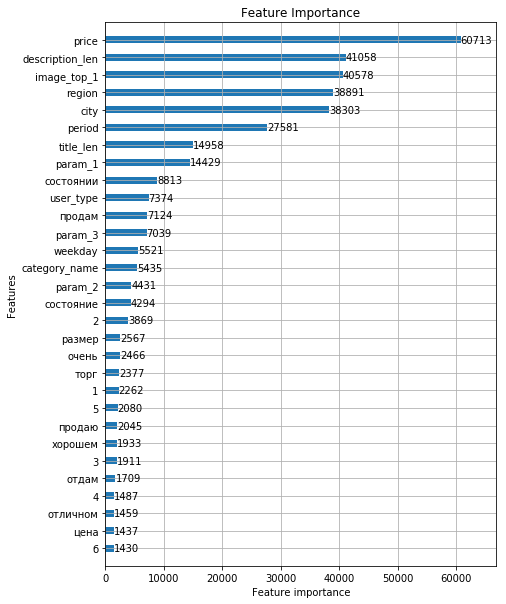

In [63]:
fig, ax = plt.subplots(figsize=[7,10])
lgb.plot_importance(lgb_1, max_num_features=30, height=0.4, ax=ax)
plt.title("Feature Importance")
plt.savefig('feature_import_lgb_1.png')

In [65]:
sub = pd.DataFrame(lgb_1_preds.clip(0.0,1.0), columns=["deal_probability"])
sub.to_csv('lgb_1_sub.csv')

In [ ]:
lgb_1_v2_param = {
    'objective': 'regression',
    'boosting_type': 'gbdt',
    'learning_rate': 0.015,
    'num_boost_round': 1000,
    'max_depth': 15,
    'num_leaves': 400,
    'verbose_eval': 20
}

m = lgb.LGBMRegressor(**lgb_1_v2_param, early_stopping_rounds=50)
lgb_1_v2, lgb_1_v2_preds = train_predict(m)

# RMSE on valid:  0.22242638643714888

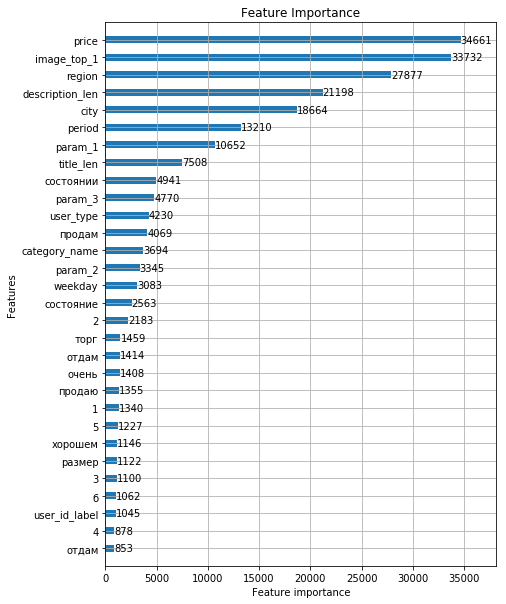

In [84]:
fig, ax = plt.subplots(figsize=[7,10])
lgb.plot_importance(lgb_1_v2, max_num_features=30, height=0.4, ax=ax)
plt.title("Feature Importance")
plt.savefig('feature_import_lgb_1_v2.png')

In [85]:
sub = pd.DataFrame(lgb_1_v2_preds.clip(0.0,1.0), columns=["deal_probability"])
sub.to_csv('lgb_1_v2_sub.csv')

In [ ]:
lgb_2_param = {
    'objective': 'regression',
    'boosting_type': 'gbdt',
    'learning_rate': 0.025,
    'max_depth': 15,
    'num_leaves': 400,
    'num_boost_round': 500
}

lgb_2 = lgb.LGBMRegressor(**lgb_2_param, early_stopping_rounds=10)
lgb_2_oof_train, lgb_2_preds = get_oof(lgb_2, x_train, y_train, x_test)

In [74]:
level_1_train = pd.DataFrame(lgb_2_oof_train, columns=['lgb_2_oof_train'])
level_1_test = pd.DataFrame(lgb_2_preds, columns=['lgb_2_preds'])

In [ ]:
from sklearn.linear_model import Ridge

ridge_1_param = {
    'alpha':30.0, 
    'fit_intercept':True, 
    'normalize':False, 
    'copy_X':True,
    'max_iter':None, 
    'tol':0.001, 
    'solver':'auto', 
    'random_state': 7
}
ridge_1 = Ridge(**ridge_1_param)

ridge_1_oof_train, ridge_1_preds = get_oof_2(ridge_1, x_train, y_train, x_test)


In [88]:
level_1_train['ridge_1_oof_train'] = ridge_1_oof_train
level_1_test['ridge_1_preds'] = ridge_1_preds

In [93]:
del x_train, x_test

LGB and Ridge models trained using:
- numeric features
- categorical features
- dense text features: tfidf on text and description)

In [102]:
x_train = pd.concat([df[:ntrain], title_svd_df[:ntrain], desc_svd_df[:ntrain]],
                   axis=1)
x_test = pd.concat([df[ntrain:], title_svd_df[ntrain:], desc_svd_df[ntrain:]],
                   axis=1)


In [104]:
x_tr, x_val, y_tr, y_val = train_test_split(
        x_train, y_train, test_size=0.20, random_state=23)

In [ ]:
lgb_3_param = {
    'objective': 'regression',
    'boosting_type': 'gbdt',
    'learning_rate': 0.015,
    'num_boost_round': 1000,
    'max_depth': 15,
    'num_leaves': 400,
    'verbose_eval': 20
}

feature_name = x_train.columns.tolist()
m = lgb.LGBMRegressor(**lgb_3_param, early_stopping_rounds=50)
lgb_3, lgb_3_preds = train_predict(m)

# RMSE on valid: 0.2221721694025877

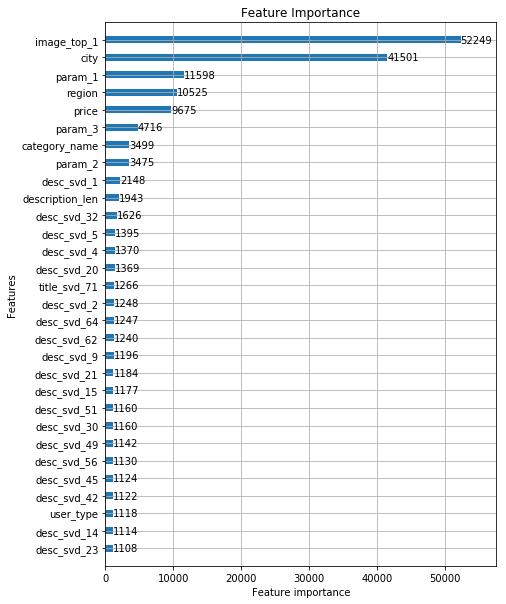

In [108]:
fig, ax = plt.subplots(figsize=[7,10])
lgb.plot_importance(lgb_3, max_num_features=30, height=0.4, ax=ax)
plt.title("Feature Importance")
plt.savefig('feature_import_lgb_3.png')

In [109]:
sub = pd.DataFrame(lgb_3_preds.clip(0.0,1.0), columns=["deal_probability"])
sub.to_csv('lgb_3_sub.csv')

In [ ]:
ridge_2_param = {
    'alpha':30.0, 
    'fit_intercept':True, 
    'normalize':False, 
    'copy_X':True,
    'max_iter':None, 
    'tol':0.001, 
    'solver':'auto', 
    'random_state': 7
}
ridge_2 = Ridge(**ridge_2_param)

ridge_2_oof_train, ridge_2_preds = get_oof_2(ridge_2, x_train, y_train, x_test)

In [131]:
level_1_train['ridge_2_oof_train'] = ridge_2_oof_train
level_1_test['ridge_2_preds'] = ridge_2_preds

In [ ]:
lgb_4_param = {
    'objective': 'regression',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'max_depth': 15,
    'num_leaves': 400,
    'num_boost_round': 500
}

lgb_4 = lgb.LGBMRegressor(**lgb_4_param, early_stopping_rounds=10)
lgb_4_oof_train, lgb_4_preds = get_oof(lgb_4, x_train, y_train, x_test)


In [121]:
level_1_train['lgb_4_oof_train'] = lgb_4_oof_train
level_1_test['lgb_4_preds'] = lgb_4_preds

## Stacking Base Models

### Simple stacking by mean

In [143]:
l2_simple = level_1_test.apply(lambda row: row.mean(), axis=1)

In [144]:
sub = pd.DataFrame(l2_simple.clip(0.0,1.0), columns=['deal_probability'])
sub.to_csv('l2_simple_sub.csv')

### Stacking with important features
Level 2 models: 
- LightGBM
- Neural network
- Ridge

In [211]:
feature = ['price', 'image_top_1', 'param_1', 'city', 'region', 'category_name', 'period', 'param_3', 'param_2']
l1_train = pd.concat([level_1_train, df[:ntrain][feature]], axis=1)
l1_test = pd.concat([level_1_test, df[ntrain:][feature].reset_index()], axis=1)
l1_test.drop(['index'], axis=1, inplace=True)

In [147]:
x_tr, x_val, y_tr, y_val = train_test_split(
        l1_train, y_train, test_size=0.20, random_state=16)

In [ ]:
# lgb
lgb_5_param = {
    'objective': 'regression',
    'boosting_type': 'gbdt',
    'learning_rate': 0.01,
    'max_depth': 8,
    'num_leaves': 400,
    'metric': 'rmse'
}

cat = ['image_top_1', 'param_1', 'city', 'region', 'category_name', 'param_3', 'param_2']

lgbtrain = lgb.Dataset(x_tr, y_tr, categorical_feature=cat)
lgbvalid = lgb.Dataset(x_val, y_val, categorical_feature=cat)

lgb_5 = lgb.train(
    lgb_5_param,
    lgbtrain,
    num_boost_round=1000,
    valid_sets=[lgbvalid],
    valid_names=['valid'],
    early_stopping_rounds=100,
    verbose_eval=100)


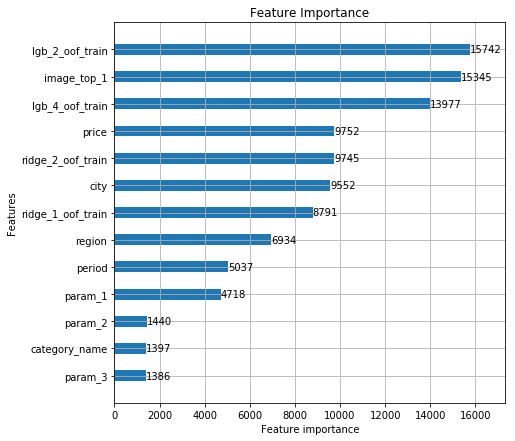

In [160]:
fig, ax = plt.subplots(figsize=[7,7])
lgb.plot_importance(lgb_5, height=0.4, ax=ax)
plt.title("Feature Importance")
plt.savefig('feature_import_lgb_5.png')

In [180]:
lgb_5_preds = lgb_5.predict(l1_test)
lgb_5_train = lgb_5.predict(l1_train)

sub = pd.DataFrame(lgb_5_preds.clip(0.0,1.0), columns=['deal_probability'])
sub.to_csv('lgb_5_sub.csv')

In [ ]:
lgb_5_oof = lgb.LGBMRegressor(**lgb_5_param, num_boost_round=1000, early_stopping_rounds=100)
lgb_5_oof_train, lgb_5_oof_preds = get_oof(lgb_5_oof, l1_train, y_train, l1_test)

sub = pd.DataFrame(lgb_5_oof_preds.clip(0.0,1.0), columns=['deal_probability'])
sub.to_csv('lgb_5_oof_sub.csv')

In [ ]:
# Neural network
from keras.layers import Dense
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.wrappers import scikit_learn

def create_model():
    model = Sequential()
    model.add(Dense(13, input_dim=13, kernel_initializer='normal', activation='relu'))
    model.add(Dense(6, kernel_initializer='normal'))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

early_stopping = EarlyStopping(patience=3)

nn_1 = scikit_learn.KerasRegressor(build_fn=create_model)

nn_1.fit(x_tr, y_tr,
         validation_data=(x_val, y_val), 
         epochs=10, callbacks=[early_stopping])

In [222]:
nn_1_preds = nn_1.predict(l1_test)
nn_1_train = nn_1.predict(l1_train)

sub = pd.DataFrame(nn_1_preds.clip(0.0,1.0), columns=['deal_probability'])
sub.to_csv('nn_1_sub.csv')

In [238]:
# Ridge
ridge_3_param = {
    'alpha':1.0,
    'fit_intercept':True,
    'normalize':False,
    'copy_X':True,
    'tol':0.001, 
    'solver':'auto', 
    'random_state': 7
}
ridge_3 = Ridge(**ridge_3_param)

ridge_3.fit(l1_train, y_train)

ridge_3_preds = ridge_3.predict(l1_test)
ridge_3_train = ridge_3.predict(l1_train)

sub = pd.DataFrame(ridge_3_preds.clip(0.0,1.0), columns=['deal_probability'])
sub.to_csv('ridge_3_sub.csv')

In [246]:
ridge_3_oof = Ridge(**ridge_3_param)
ridge_3_oof_train, ridge_3_oof_preds = get_oof_2(ridge_3_oof, l1_train, y_train, l1_test)

sub = pd.DataFrame(ridge_3_oof_preds.clip(0.0,1.0), columns=['deal_probability'])
sub.to_csv('ridge_3_oof_sub.csv')

### Model | RMSE Score 

- LightGBM (lgb_5_oof) | 0.2239

- Neural network (nn1) | 0.2249

- Ridge (ridge_3_oof) | 0.2244

- Simple stacking (l2_simple) | 0.2334